In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct  8 14:51:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install --user --upgrade tensorflow-model-optimization

In [ ]:
import tensorflow as tf
# import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras import regularizers
# from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing Dataset

In [ ]:
training = '/content/drive/MyDrive/Data'
# validation = '/content/drive/MyDrive/Dataset/No DR'
testing = '/content/drive/MyDrive/Test'

train_batches = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, vertical_flip=True, validation_split=0.2, rescale=1./255).flow_from_directory(directory=training, target_size=(224,224), class_mode='binary', batch_size=64, subset='training')
valid_batches = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, vertical_flip=True, validation_split=0.2, rescale=1./255).flow_from_directory(directory=training, target_size=(224,224), class_mode = 'binary', batch_size=64, subset='validation')
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=testing, target_size=(224,224), batch_size=64, class_mode = 'binary', shuffle=False)

Found 27467 images belonging to 2 classes.
Found 6865 images belonging to 2 classes.
Found 790 images belonging to 2 classes.


In [ ]:
imgs, labels = next(train_batches)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # img = img.swapaxes(0,1)
        # img = img.swapaxes(1,2)
        ax.imshow(img)       
        ax.axis('off')
    plt.tight_layout()
    plt.show()

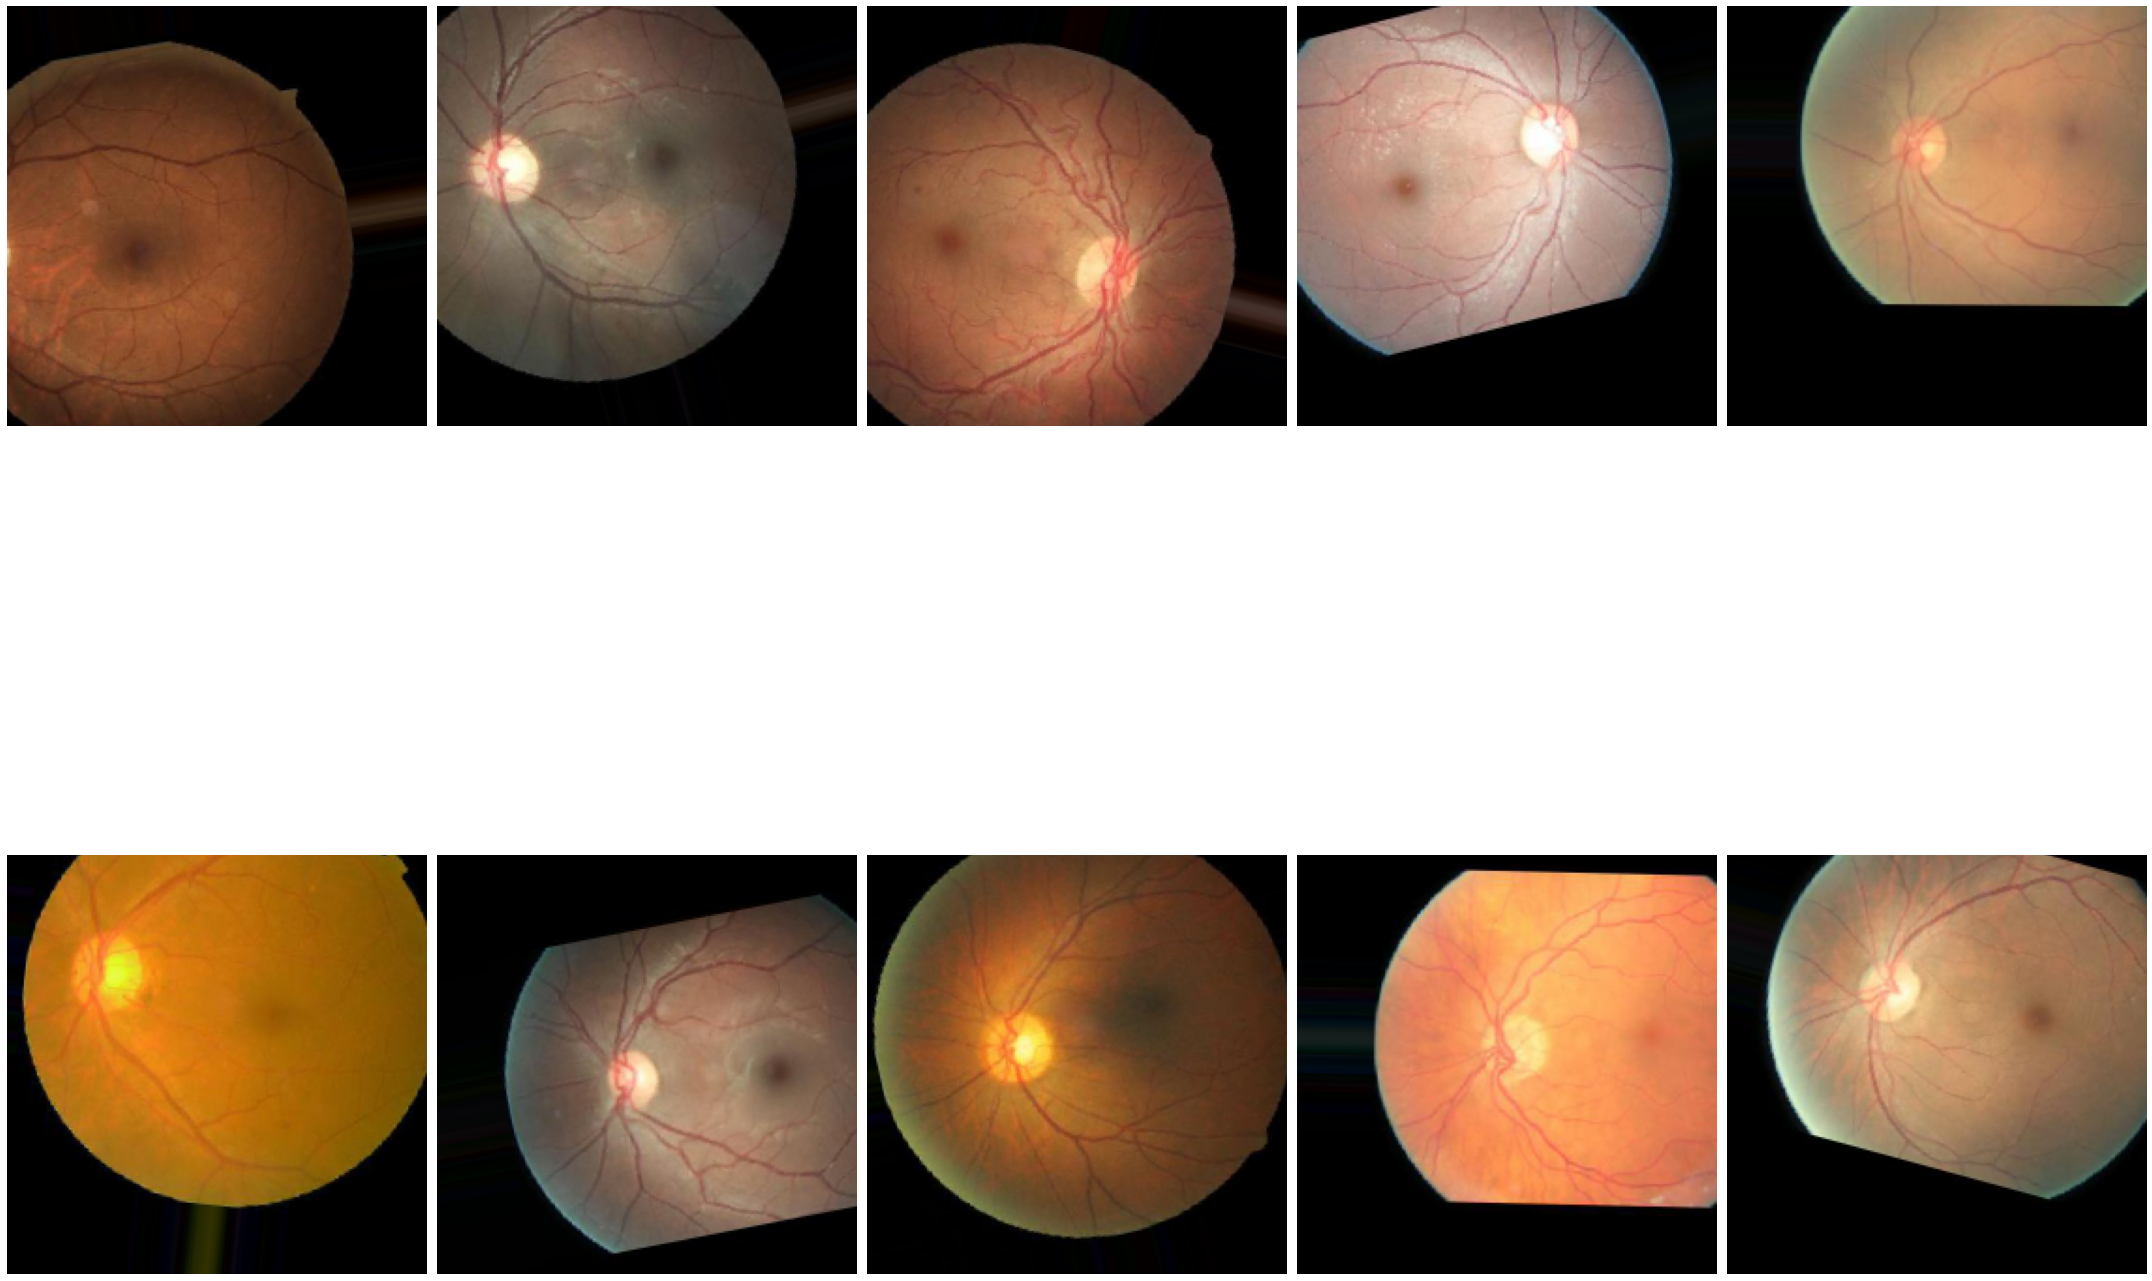

In [ ]:
plotImages(imgs)

## Defining Model

In [ ]:
resnet_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',
include_top=False,
input_shape=(224, 224, 3))

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 30,010,369
Trainable params: 29,957,249
No

In [ ]:
# Make last block of the resnet_model trainable:

for layer in resnet_model.layers[:165]:
   layer.trainable = False
for layer in resnet_model.layers[165:]:
   layer.trainable = True

print('Last block of the resnet_model is now trainable')

Last block of the resnet_model is now trainable


In [ ]:
for i, layer in enumerate(resnet_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 30,010,369
Trainable params: 10,888,321
No

## Compile Model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

## Callbacks

In [ ]:
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights = True, verbose=1)

## Training and Validating Model

In [ ]:
history = model.fit(x=train_batches,
                    steps_per_epoch=train_batches.samples // 64,
                    validation_data=valid_batches,
                    validation_steps=valid_batches.samples // 64,
                    epochs=100,
                    verbose=1,
                    callbacks=[stopping]
)

Epoch 1/100
429/429 [==============================] - 18113s 42s/step - loss: 0.6380 - accuracy: 0.7384 - val_loss: 0.5938 - val_accuracy: 0.7405
Epoch 2/100
429/429 [==============================] - 408s 952ms/step - loss: 0.6045 - accuracy: 0.7399 - val_loss: 0.5879 - val_accuracy: 0.7405
Epoch 3/100
429/429 [==============================] - 410s 955ms/step - loss: 0.6030 - accuracy: 0.7401 - val_loss: 0.5817 - val_accuracy: 0.7396
Epoch 4/100
429/429 [==============================] - 408s 952ms/step - loss: 0.5960 - accuracy: 0.7402 - val_loss: 0.5888 - val_accuracy: 0.7401
Epoch 5/100
429/429 [==============================] - 404s 942ms/step - loss: 0.5906 - accuracy: 0.7401 - val_loss: 0.5767 - val_accuracy: 0.7401
Epoch 6/100
429/429 [==============================] - 400s 933ms/step - loss: 0.5869 - accuracy: 0.7402 - val_loss: 0.5770 - val_accuracy: 0.7404
Epoch 7/100
429/429 [==============================] - 400s 933ms/step - loss: 0.5865 - accuracy: 0.7402 - val_loss: 0

## Displaying Training and Validation Graphs

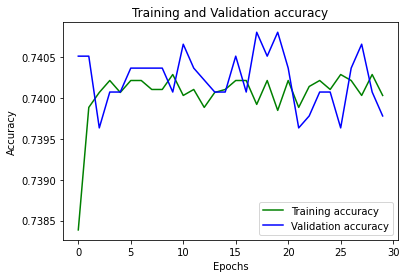

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

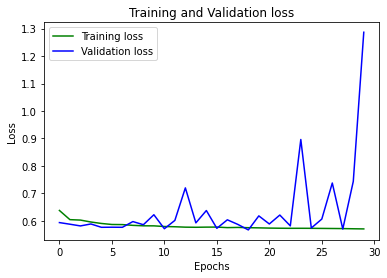

In [ ]:
train_acc = history.history['loss']
val_acc = history.history['val_loss']
plt.plot(train_acc, 'g', label='Training loss')
plt.plot(val_acc, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## ROC Curve

In [ ]:
# make a prediction
y_pred_keras = model.predict_generator(test_batches, verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_batches.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


13/13 [==============================] - 522s 43s/step


0.5463974358974358

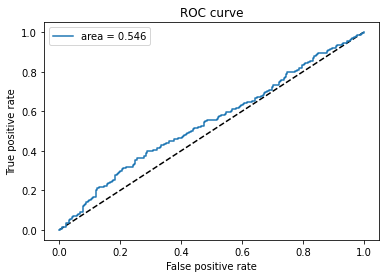

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Save TfLite Model

In [ ]:
model.save('resnet_model')

In [ ]:
# path to the SavedModel directory
saved_model_dir = 'resnet_model'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open('resnet_model.tflite', 'wb') as f:
  f.write(tflite_model)